In [ ]:
import tensorflow as tf
import torch
import tensorflow.keras.layers as layers

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

ds = tfds.load('kitti',split='validation')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/6347 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kitti/3.3.0.incompleteL1KAFP/kitti-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/423 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kitti/3.3.0.incompleteL1KAFP/kitti-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/711 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/kitti/3.3.0.incompleteL1KAFP/kitti-test.tfrecord*...:   0%|          | 0/7…

Dataset kitti downloaded and prepared to /root/tensorflow_datasets/kitti/3.3.0. Subsequent calls will reuse this data.


In [ ]:
!wget https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono_640x192.zip

!unzip mono_640x192.zip


encoder_path = 'encoder.pth'
decoder_path = 'depth.pth'

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
loaded_dict = torch.load(decoder_path, map_location='cpu')

--2023-11-22 08:52:54--  https://storage.googleapis.com/niantic-lon-static/research/monodepth2/mono_640x192.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.207, 173.194.211.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103531333 (99M) [application/zip]
Saving to: ‘mono_640x192.zip’

mono_640x192.zip    100%[===================>]  98.73M  31.6MB/s    in 3.1s    

2023-11-22 08:52:58 (31.6 MB/s) - ‘mono_640x192.zip’ saved [103531333/103531333]

Archive:  mono_640x192.zip
  inflating: depth.pth               
  inflating: encoder.pth             
  inflating: pose.pth                
  inflating: pose_encoder.pth        


In [ ]:
class ReflectionPadding2D(tf.keras.layers.Layer):
    # Defining a reflection pad layer for keras
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

    def get_config(self):
        config = super().get_config().copy()
        return config

class DepthEstimation():
  def __init__(self):
        self = self

  def ResNetBlock(self, inputs, layer, downsample=False):
    filters = inputs.shape[-1]
    filters *= 2 if downsample else 1
    strides = 2 if downsample else 1
    name = 'en.layer' + str(layer[0]) + '.' + str(layer[1]) + '.'

    featureZeroPaddingA = layers.ZeroPadding2D(1)(inputs)
    featureConvA = layers.Conv2D(filters, 3, activation='linear', use_bias=False, strides=strides, name=name + 'conv1')(featureZeroPaddingA)
    featureNormalizationA = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=name + 'bn1')(featureConvA)
    featureReLuA = layers.ReLU()(featureNormalizationA)
    featureZeroPaddingB = layers.ZeroPadding2D(1)(featureReLuA)
    featureConvB = layers.Conv2D(filters, 3, activation='linear', use_bias=False, name=name + 'conv2')(featureZeroPaddingB)
    featureNormalizationB = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=name + 'bn2')(featureConvB)

    if not downsample:
        add = featureNormalizationB + inputs
    else:
        name += 'downsample.'
        featureConvC = layers.Conv2D(filters, 1, activation='linear',
                       use_bias=False, strides=2, name=name + '0')(inputs)
        featureNormalizationC = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=name + '1')(featureConvC)
        add = featureNormalizationB + featureNormalizationC

    featureReLuB = layers.ReLU()(add)
    return featureReLuB

  def ConvolutionBlock(self, size, inTensor, disp=False, cnt=''):
    name = 'dispconv' if disp else 'upconv'
    name = 'de.' + name + '.' + str(len("{0:b}".format(size)) - 5) + '.' + cnt
    filters = 1 if disp else size
    x = ReflectionPadding2D()(inTensor)
    x = tf.keras.layers.Conv2D(filters, 3, name=name)(x)
    if not disp:
        x = tf.keras.layers.ELU()(x)
    else:
        x = tf.keras.activations.sigmoid(x)
    return x

  def UpSampling(self, size, firstTensor, secondTensor=None):
    x = self.ConvolutionBlock(size, firstTensor, cnt='0')
    x = tf.keras.layers.UpSampling2D()(x)
    if size > 16:
        x = tf.keras.layers.concatenate([x, secondTensor], axis=-1)
    x = self.ConvolutionBlock(size, x, cnt='1')
    return x

  def Encoder(self, inputs, encoder):
    inputs = (inputs - 0.45) / 0.225
    featureZeroPaddingA = layers.ZeroPadding2D(3)(inputs)
    featureConvA = layers.Conv2D(64, 7, strides=2, activation='linear', use_bias=False, name='conv1')(featureZeroPaddingA)
    featureNormalizationA = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(featureConvA)
    featureReLuA = layers.ReLU()(featureNormalizationA)
    encoder.append(featureReLuA)
    featureZeroPaddingB = layers.ZeroPadding2D(1)(featureReLuA)
    feature = layers.MaxPooling2D(3, 2)(featureZeroPaddingB)
    for i in range(1, 5):
      feature = self.ResNetBlock(feature, (i, 0), i > 1)
      feature = self.ResNetBlock(feature, (i, 1))
      encoder.append(feature)
    return encoder

  def Decoder(self, encoder, outputs):
    feature = self.UpSampling(256, encoder[4], encoder[3])
    feature = self.UpSampling(128, feature, encoder[2])
    outputs.append(self.ConvolutionBlock(128, feature, disp=True))
    feature = self.UpSampling(64, feature, encoder[1])
    outputs.append(self.ConvolutionBlock(64, feature, disp=True))
    feature = self.UpSampling(32, feature, encoder[0])
    outputs.append(self.ConvolutionBlock(32, feature, disp=True))
    feature = self.UpSampling(16, feature)
    outputs.append(self.ConvolutionBlock(16, feature, disp=True))
    outputs = outputs[::-1]
    return outputs

  def Model(self, inputs, outputs):
     model = tf.keras.Model(inputs=inputs, outputs=outputs, name='depth')
     model.get_layer('conv1').set_weights(
         [loaded_dict_enc['encoder.conv1.weight'].numpy().transpose(2, 3, 1, 0)])
     model.get_layer('bn1').set_weights(
         [loaded_dict_enc['encoder.bn1.weight'].numpy(),
          loaded_dict_enc['encoder.bn1.bias'].numpy(),
          loaded_dict_enc['encoder.bn1.running_mean'].numpy(),
          loaded_dict_enc['encoder.bn1.running_var'].numpy()])
     for layer in model.layers:
       name = layer.name.split('.')
       if name[0] == 'en':
         name = '.'.join(name[1:])
         num_weights = len(layer.get_weights())
         if num_weights == 1:
           layer.set_weights([loaded_dict_enc['encoder.' + name + '.weight'].numpy().transpose(2, 3, 1, 0)])
         else:
           layer.set_weights(
               [loaded_dict_enc['encoder.' + name + '.weight'].numpy(),
                loaded_dict_enc['encoder.' + name + '.bias'].numpy(),
                loaded_dict_enc['encoder.' + name + '.running_mean'].numpy(),
                loaded_dict_enc['encoder.' + name + '.running_var'].numpy()])

       if name[0] == 'de':
         if name[1] == 'upconv':
           num = str(2 * (4 - int(name[2])) + int(name[3]))
           layer.set_weights([loaded_dict['decoder.' + num + '.conv.conv.weight']
                              .numpy().transpose(2, 3, 1, 0),
                              loaded_dict['decoder.' + num + '.conv.conv.bias'].numpy()])
         else:
           num = str(int(name[2]) + 10)
           layer.set_weights([loaded_dict['decoder.' + num + '.conv.weight']
                              .numpy().transpose(2, 3, 1, 0),
                              loaded_dict['decoder.' + num + '.conv.bias'].numpy()])
     return model

class Util():
  def __init__(self):
        self = self
  def resize_img(self, img):
    img['image'] = tf.image.resize(img['image'],[192,640])
    return img['image']/255.
  def resize_img2(self, img):
    img['image'] = tf.image.resize(img['image'],[512,512])
    return img['image']/255.

In [ ]:
def run():
  #--------------------------
  # TRANNING
  #--------------------------
  inputs = layers.Input(shape=(192,640,3))
  encoder = []
  outputs = []
  encoder = DepthEstimation().Encoder(inputs, encoder)
  outputs = DepthEstimation().Decoder(encoder, outputs)
  model = DepthEstimation().Model(inputs, outputs)

  #--------------------------
  # PREDICTION AND VISUALIZATION
  #--------------------------
  ds_eval = ds.map(Util().resize_img).batch(32).prefetch(tf.data.AUTOTUNE)
  input_images = ds_eval.take(1)
  val = 25

  result_img = model.predict(input_images)

  for img in input_images:
    imin = img[val]
  imout = result_img[0][val].reshape(192,640)
  print(imout)
  print(imout.shape)
  print(imin.shape)
  f, axes = plt.subplots(2,figsize=(20,10))
  axes[0].imshow(imout)
  axes[1].imshow(imin);

1/1 [==============================] - 16s 16s/step
[[0.23512559 0.23299366 0.2317844  ... 0.42272422 0.42399827 0.42939866]
 [0.23512183 0.23296256 0.2317882  ... 0.4220969  0.42302904 0.4277947 ]
 [0.23499684 0.2328997  0.23180258 ... 0.42417505 0.425152   0.43006518]
 ...
 [0.9978965  0.9978639  0.99785525 ... 0.9999956  0.99999565 0.9999957 ]
 [0.9979586  0.99793017 0.99792385 ... 0.99999577 0.9999958  0.9999959 ]
 [0.9979686  0.9979419  0.99793386 ... 0.99999577 0.9999958  0.9999958 ]]
(192, 640)
(192, 640, 3)


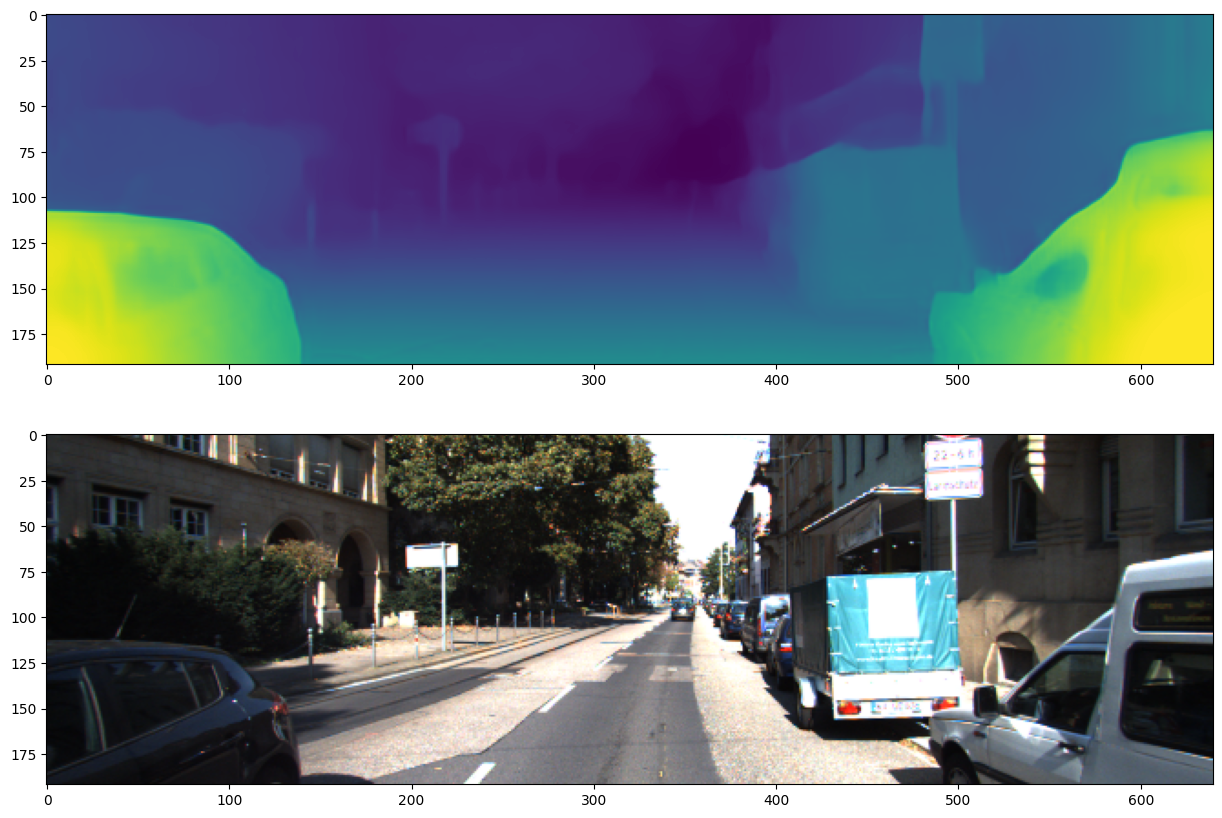

In [ ]:
#--------------------------
# MAIN
#--------------------------
if __name__ == '__main__':
  run()

In [ ]:
  inputs = layers.Input(shape=(192,640,3))
  encoder = []
  outputs = []
  encoder = DepthEstimation().Encoder(inputs, encoder)
  outputs = DepthEstimation().Decoder(encoder, outputs)
  model = DepthEstimation().Model(inputs, outputs)

  ds_eval = ds.map(Util().resize_img).batch(32).prefetch(tf.data.AUTOTUNE)
  input_images = ds_eval.take(1)
  val = 25
  result_img = model.predict(input_images)

  for img in input_images:
    imin = img[val]
  imout = result_img[0][val].reshape(192,640)

1/1 [==============================] - 16s 16s/step


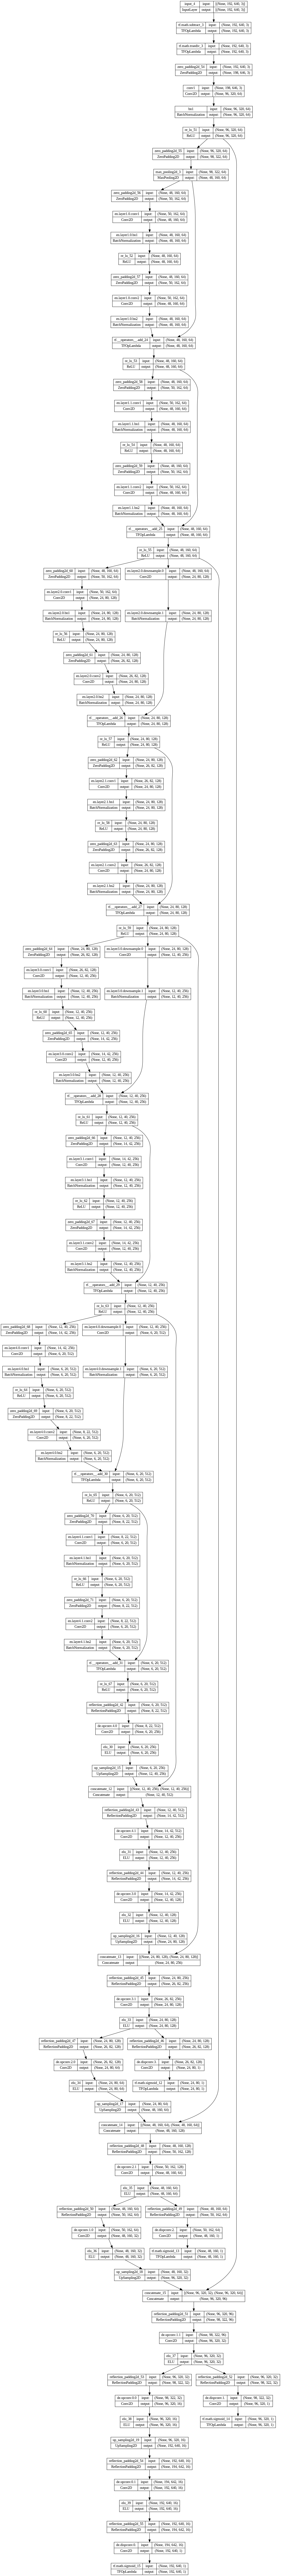

In [ ]:
from tensorflow.keras.utils import plot_model


plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


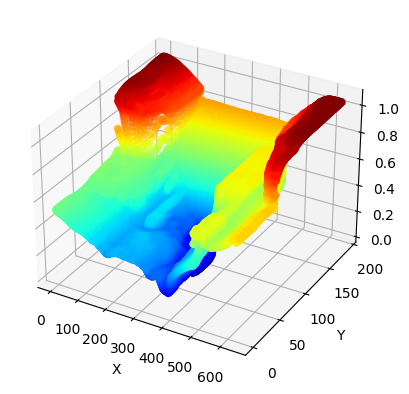

In [ ]:
import cv2
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Função para calcular as coordenadas 3D
def calculate_3d_coordinates(image_coordinates, depth, camera_matrix, distortion_coeffs):
    # Adicionar o valor de profundidade às coordenadas de imagem
    image_coordinates_depth = np.array([[image_coordinates[0], image_coordinates[1]]], dtype=np.float32)

    # Corrigir as coordenadas de imagem usando os coeficientes de distorção
    undistorted_coordinates = cv2.undistortPoints(image_coordinates_depth, camera_matrix, distortion_coeffs, P=camera_matrix)

    # Multiplicar as coordenadas corrigidas pela profundidade para obter as coordenadas 3D
    coordinates_3d = np.append(undistorted_coordinates[0][0], depth)
    return coordinates_3d

# Carregar a matriz da câmera e os coeficientes de distorção
camera_matrix = np.array([[2.95389836e+03, 0.00000000e+00, 1.59195353e+03],
                          [0.00000000e+00, 2.60746459e+03, 1.28217291e+03],
                          [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

distortion_coeffs = np.array([[-0.56239355, 0.25599173, 0.16078187, 0.01695844, -0.17199612]])

depth_map = imout
image_height, image_width = depth_map.shape
valid_coordinates = []

for y in range(image_height):
    for x in range(image_width):
        depth = depth_map[y, x]

        if 0 <= depth <= 1:
            image_coordinates = (x, y)
            coordinates_3d = calculate_3d_coordinates(image_coordinates, depth, camera_matrix, distortion_coeffs)

            valid_coordinates.append(coordinates_3d)

valid_coordinates = np.array(valid_coordinates)

# Escala logarítmica para ajustar a profundidade
valid_coordinates[:, 2] = np.log10(valid_coordinates[:, 2] * 10 + 1)

# Plotagem da imagem 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(valid_coordinates[:, 0], valid_coordinates[:, 1], valid_coordinates[:, 2], c=valid_coordinates[:, 2], cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


plt.show()


In [ ]:
import plotly.graph_objects as go

# Dados das coordenadas
x = valid_coordinates[:, 0]
y = valid_coordinates[:, 1]
z = valid_coordinates[:, 2]

# Criação da figura 3D
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',
                                   marker=dict(color=z, colorscale='Viridis', cmin=min(z), cmax=max(z)))])
# Configuração dos eixos
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Y',
    zaxis_title='Z'
))

# Exibição da figura
fig.show()


In [ ]:
inputs = layers.Input(shape=(192,640,3))
encoder = []
outputs = []
encoder = DepthEstimation().Encoder(inputs, encoder)
outputs = DepthEstimation().Decoder(encoder, outputs)
model = DepthEstimation().Model(inputs, outputs)

path = '/content/tf'
tf.saved_model.save(model, path)

In [ ]:
modelPreFinal = tf.saved_model.load(path)

In [ ]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(path) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('model_alfa.tflite', 'wb') as f:
  f.write(tflite_model)

In [ ]:
TFLITE_MODEL = "model_alfa.tflite"

interpreter = tf.lite.Interpreter(model_path=TFLITE_MODEL)
interpreter.allocate_tensors()
print("== Input details ==")
print("name:", interpreter.get_input_details()[0]['name'])
print("shape:", interpreter.get_input_details()[0]['shape'])
print("type:", interpreter.get_input_details()[0]['dtype'])

print("\nDUMP INPUT")
print(interpreter.get_input_details()[0])

print("\n== Output details ==")
print("name:", interpreter.get_output_details()[0]['name'])
print("shape:", interpreter.get_output_details()[0]['shape'])
print("type:", interpreter.get_output_details()[0]['dtype'])

print("\nDUMP OUTPUT")
print(interpreter.get_output_details()[0])


== Input details ==
name: serving_default_input_5:0
shape: [  1 192 640   3]
type: <class 'numpy.float32'>

DUMP INPUT
{'name': 'serving_default_input_5:0', 'index': 0, 'shape': array([  1, 192, 640,   3], dtype=int32), 'shape_signature': array([ -1, 192, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}

== Output details ==
name: StatefulPartitionedCall:3
shape: [  1 192 640   1]
type: <class 'numpy.float32'>

DUMP OUTPUT
{'name': 'StatefulPartitionedCall:3', 'index': 174, 'shape': array([  1, 192, 640,   1], dtype=int32), 'shape_signature': array([ -1, 192, 640,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}